In [52]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import os, pickle

path = '/content/drive/My Drive/Colab Notebooks/Udemy/fruits-360'
os.chdir(path)
os.listdir()

IMAGE_SIZE = [100, 100] # feel free to change depending on dataset
epochs, batch_size = 25, 32

train_path = '../fruits-360/fruits-360_reduced/Training'
valid_path  = '../fruits-360/fruits-360_reduced/Test'

imgs_train = glob( train_path + '/*/*.jp*g')
imgs_valid  = glob( valid_path + '/*/*.jp*g')

# useful for getting number of classes
classes = ['Apple Pink Lady', 'Avocado', 'Kiwi', 'Lemon', 'Mango', 'Banana', 'Peach']
folders = glob(train_path + '/*')

['../fruits-360/fruits-360_reduced/Training/Apple Golden 1',
 '../fruits-360/fruits-360_reduced/Training/Avocado',
 '../fruits-360/fruits-360_reduced/Training/Kiwi',
 '../fruits-360/fruits-360_reduced/Training/Lemon',
 '../fruits-360/fruits-360_reduced/Training/Mango',
 '../fruits-360/fruits-360_reduced/Training/Banana',
 '../fruits-360/fruits-360_reduced/Training/Peach']

In [2]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

gen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = gen.flow_from_directory( train_path, target_size=IMAGE_SIZE, shuffle=True, batch_size=batch_size)
valid_generator = gen.flow_from_directory(  valid_path, target_size=IMAGE_SIZE, shuffle=True, batch_size=batch_size)

load_model, filename = 0, 'finalized_model.sav'
if(load_model):
    # ----------------- Load Model ----------------- #
    filename = 'finalized_model.sav'
    model = pickle.load( open(filename, 'rb'))
else:
    # ----------------- Train Model ---------------- #
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(folders), activation='softmax')(x)
    # ------ pre-trained CNN & new classifier ------ #
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    # ------------- Data Augmenetation ------------- #
    gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.2, horizontal_flip=True,
    vertical_flip=True, preprocessing_function=preprocess_input)
    # --------------- Train the model-- ------------ #  
    r = model.fit_generator( train_generator, validation_data=valid_generator,
    epochs=epochs, steps_per_epoch=len(imgs_train) // batch_size,
    validation_steps=len(imgs_valid) // batch_size )
    # ----------------- Save Model ----------------- #
    pickle.dump(model, open(filename, 'wb'))

y_true, Y_pred = valid_generator.classes, model.predict_generator( valid_generator )
y_pred = np.argmax(Y_pred, axis=1)

from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)    


# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
# for layer in model.layers[:249]: # <-- (!) check (!)
#    layer.trainable = False
# for layer in model.layers[249:]:
#    layer.trainable = True


Found 3349 images belonging to 7 classes.
Found 1123 images belonging to 7 classes.
Epoch 1/25
104/104 [==============================] - 46s 439ms/step - loss: 1.3183 - accuracy: 0.5954 - val_loss: 22.6712 - val_accuracy: 0.1268
Epoch 2/25
104/104 [==============================] - 23s 222ms/step - loss: 0.3875 - accuracy: 0.9126 - val_loss: 14.0926 - val_accuracy: 0.6444
Epoch 3/25
104/104 [==============================] - 23s 220ms/step - loss: 0.3009 - accuracy: 0.9454 - val_loss: 5.7691 - val_accuracy: 0.6517
Epoch 4/25
104/104 [==============================] - 23s 221ms/step - loss: 0.3008 - accuracy: 0.9530 - val_loss: 467.7982 - val_accuracy: 0.5206
Epoch 5/25
104/104 [==============================] - 23s 224ms/step - loss: 0.1544 - accuracy: 0.9762 - val_loss: 0.4906 - val_accuracy: 0.8882
Epoch 6/25
104/104 [==============================] - 23s 222ms/step - loss: 0.2572 - accuracy: 0.9747 - val_loss: 0.8083 - val_accuracy: 0.8203
Epoch 7/25
104/104 [======================

0.1495992876224399

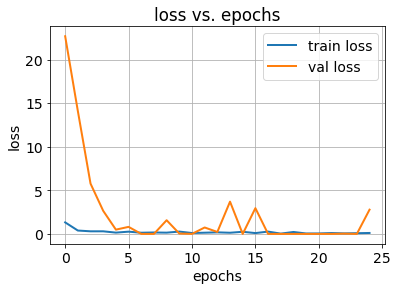

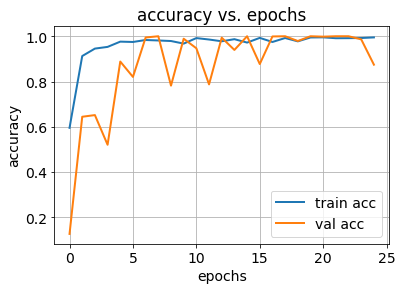

(None, <matplotlib.legend.Legend at 0x7fe7cd8ffd30>, None)

In [26]:
# ----------- Data visualization ----------- #
plt.xlabel('epochs'), plt.ylabel('loss'), plt.title('loss vs. epochs')
plt.plot(r.history['loss'], label='train loss', linewidth=2)
plt.plot(r.history['val_loss'], label='val loss', linewidth=2)
plt.grid(), plt.legend(), plt.show()

plt.xlabel('epochs'), plt.ylabel('accuracy'), plt.title('accuracy vs. epochs')
plt.plot(r.history['accuracy'], label='train acc', linewidth=2)
plt.plot(r.history['val_accuracy'], label='val acc', linewidth=2)
plt.grid(), plt.legend(), plt.show()


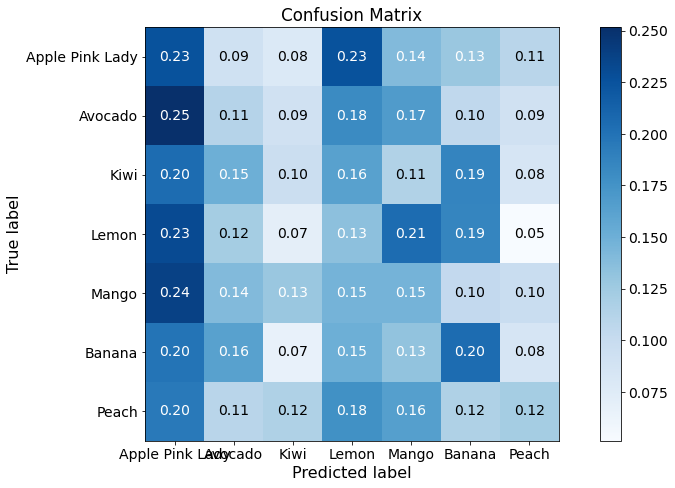

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# --------- Plot confusion Matrix --------- #
normalize = 1
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes,
        title='Confusion Matrix', ylabel='True label', xlabel='Predicted label')

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.rcParams.update({'font.size': 14})
plt.ylabel('True label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.tight_layout()

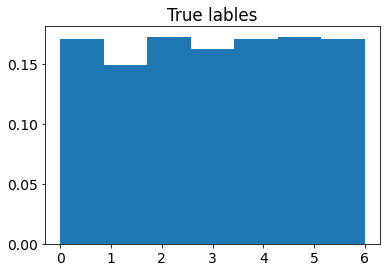

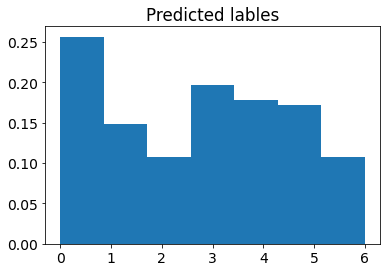

(Text(0.5, 1.0, 'Predicted lables'), None)

In [62]:
plt.hist(y_true, bins=len(folders), density=True)
plt.title('True lables'), plt.show()

plt.hist(y_pred, bins=len(folders), density=True)
plt.title('Predicted lables'), plt.show()